<a href="https://colab.research.google.com/github/lukman-17/Stock-Analysis-and-Prediction/blob/main/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install ta

In [ ]:
# !pip install TA-Lib
# !pip install ta

In [ ]:
# pip install yfinance

In [ ]:
# pip install pmdarima


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
import datetime
warnings.filterwarnings("ignore")

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Define the ticker and date range
ticker = '^FTSE'
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=5 * 365)  # Approximate 5 years

# Download data
data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='1d')

# Display the first few rows
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^FTSE        ^FTSE        ^FTSE        ^FTSE        ^FTSE   
Date                                                                          
2019-12-27  7644.899902  7644.899902  7665.399902  7622.500000  7632.200195   
2019-12-30  7587.100098  7587.100098  7644.899902  7587.100098  7644.899902   
2019-12-31  7542.399902  7542.399902  7587.399902  7532.399902  7587.100098   
2020-01-02  7604.299805  7604.299805  7624.799805  7542.399902  7542.399902   
2020-01-03  7622.399902  7622.399902  7626.399902  7551.000000  7604.299805   

Price          Volume  
Ticker          ^FTSE  
Date                   
2019-12-27  311117100  
2019-12-30  304247900  
2019-12-31  212142200  
2020-01-02  482206700  
2020-01-03  475628900  


In [ ]:
data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^FTSE,^FTSE,^FTSE,^FTSE,^FTSE,^FTSE
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,7262.879273,7262.879273,7307.048540,7217.917321,7262.523753,8.481276e+08
std,693.314835,693.314835,682.557511,705.297767,692.917635,3.207009e+08
min,4993.899902,4993.899902,5181.000000,4898.799805,4993.899902,0.000000e+00
25%,6969.000000,6969.000000,7019.799805,6917.450195,6969.000000,6.502118e+08
50%,7413.399902,7413.399902,7462.200195,7368.399902,7413.399902,7.855081e+08
75%,7667.750000,7667.750000,7694.050049,7632.200195,7666.299805,9.745285e+08
max,8445.799805,8445.799805,8474.400391,8427.900391,8445.799805,2.813498e+09


In [ ]:
# Calculate daily returns and trend
data['Return'] = data['Adj Close'].pct_change()
data['Trend'] = data['Return'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# Calculate EMAs
data['EMA10'] = data['Adj Close'].ewm(span=10, adjust=False).mean()
data['EMA20'] = data['Adj Close'].ewm(span=20, adjust=False).mean()
data['EMA50'] = data['Adj Close'].ewm(span=50, adjust=False).mean()


In [ ]:

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Ensure 'Adj Close' is a Series
data['Adj Close'] = data['Adj Close'].squeeze()

# Calculate Returns and Trend
data['Return'] = data['Adj Close'].pct_change()
data['Trend'] = data['Return'].apply(lambda x: 1 if x > 0 else 0)

# Moving Averages
data['MA10'] = data['Adj Close'].rolling(window=10).mean()
data['MA20'] = data['Adj Close'].rolling(window=20).mean()
data['MA50'] = data['Adj Close'].rolling(window=50).mean()

# Exponential Moving Average
data['EMA'] = data['Adj Close'].ewm(span=20, adjust=False).mean()

In [ ]:
# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Adj Close'], window=14).rsi()

# Calculate Bollinger Bands
data['BB_upper'] = data['Adj Close'].rolling(window=20).mean() + 2 * data['Adj Close'].rolling(window=20).std()
data['BB_lower'] = data['Adj Close'].rolling(window=20).mean() - 2 * data['Adj Close'].rolling(window=20).std()


In [ ]:
# Add lag features
data['Lag1'] = data['Adj Close'].shift(1)
data['Lag2'] = data['Adj Close'].shift(2)


In [ ]:
# Add date-related features
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter
data['Year'] = data.index.year


In [ ]:
# Drop rows with NaN values
data.dropna(inplace=True)


# Exploratory Data Analysis (EDA)


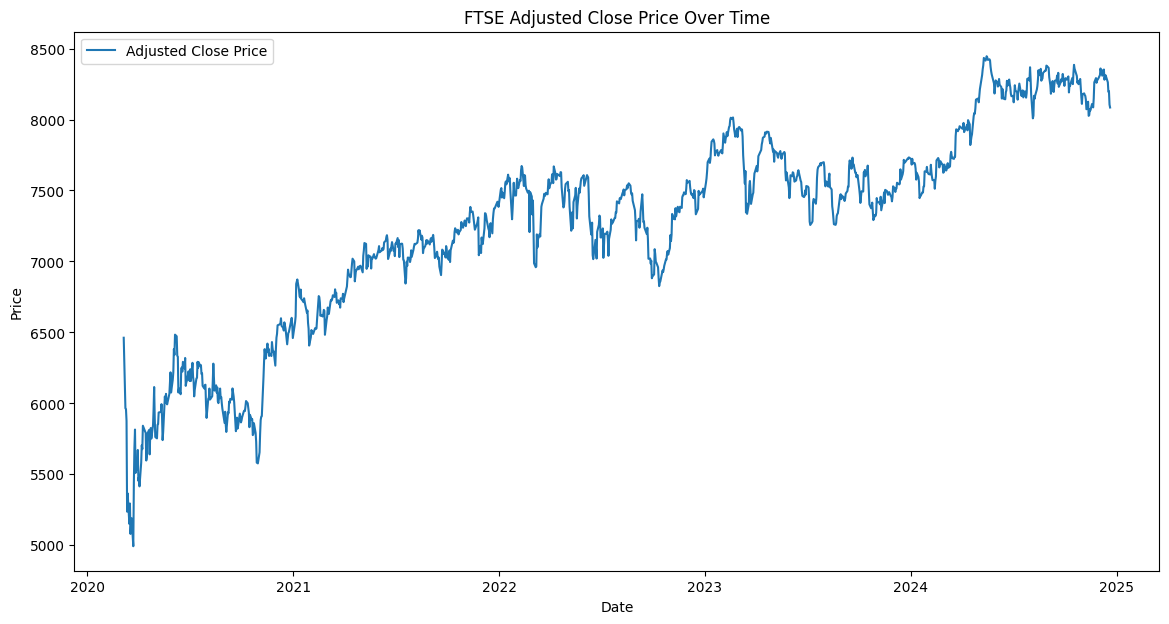

In [ ]:
# Plot Adjusted Close Price over time
plt.figure(figsize=(14,7))
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.title('FTSE Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


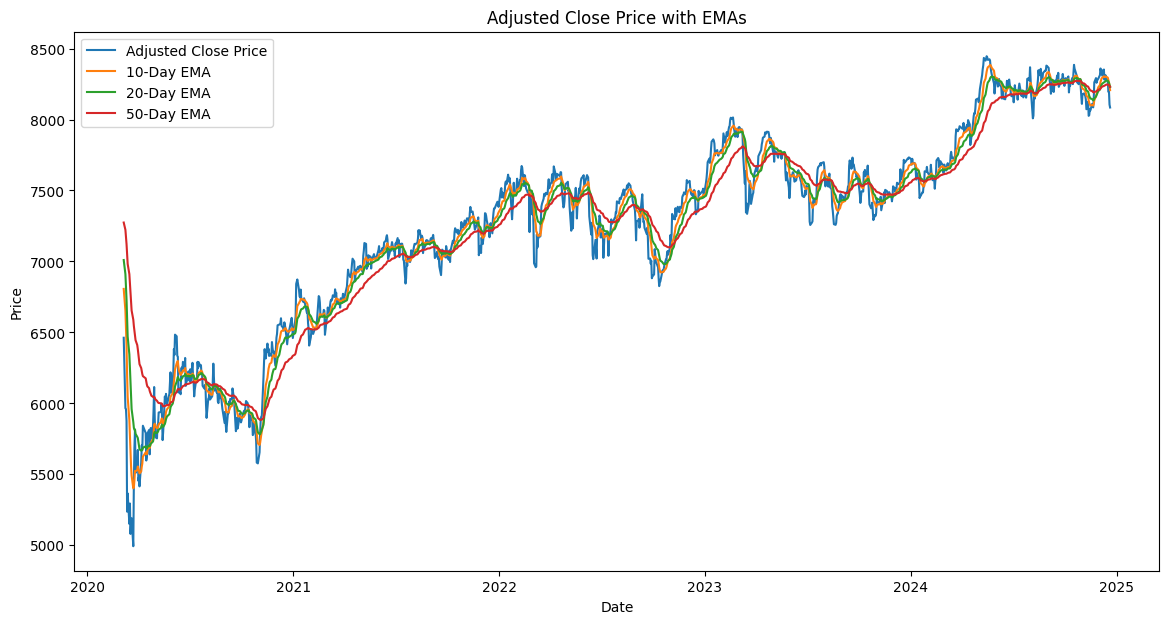

In [ ]:
# Plot Adjusted Close Price with EMAs
plt.figure(figsize=(14,7))
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.plot(data['EMA10'], label='10-Day EMA')
plt.plot(data['EMA20'], label='20-Day EMA')
plt.plot(data['EMA50'], label='50-Day EMA')
plt.title('Adjusted Close Price with EMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Split Data into Training and Testing Sets

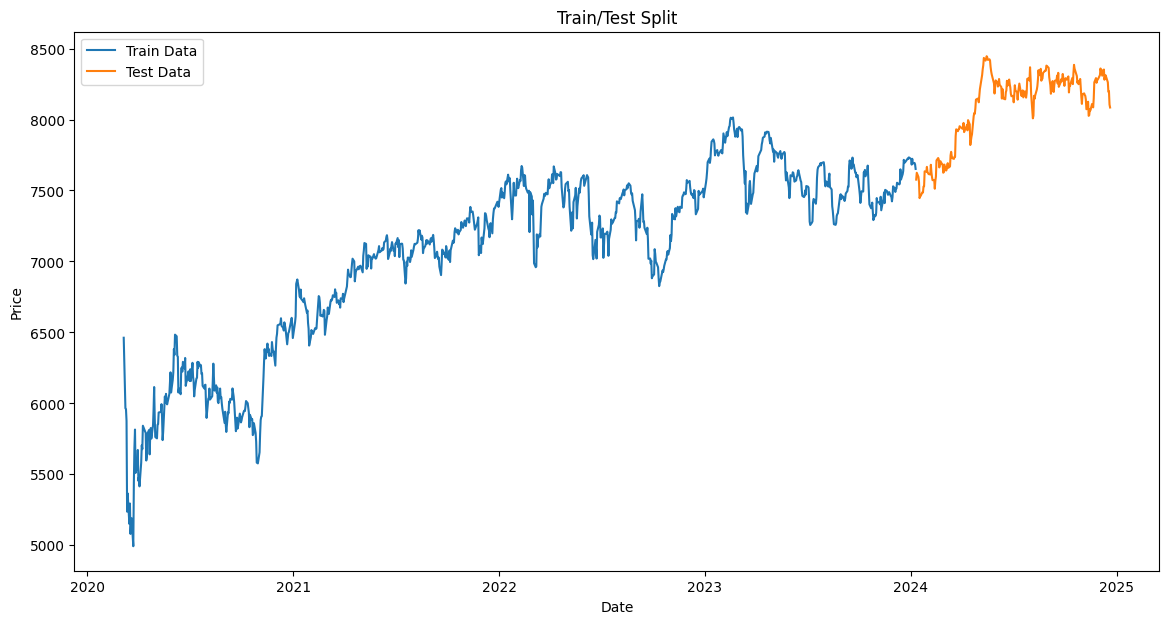

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Visualize Train and Test data
plt.figure(figsize=(14,7))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Test Data')
plt.title('Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Augmented Dickey Fuller Test

In [ ]:
result = adfuller(data['Adj Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis")
    print("Reject the null hypothesis")
    print("Data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis")
    print("Fail to reject the null hypothesis")
    print("Data has a unit root and is non-stationary")

ADF Statistic: -1.960442
p-value: 0.304182
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Weak evidence against null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


###pacf and acf Plot

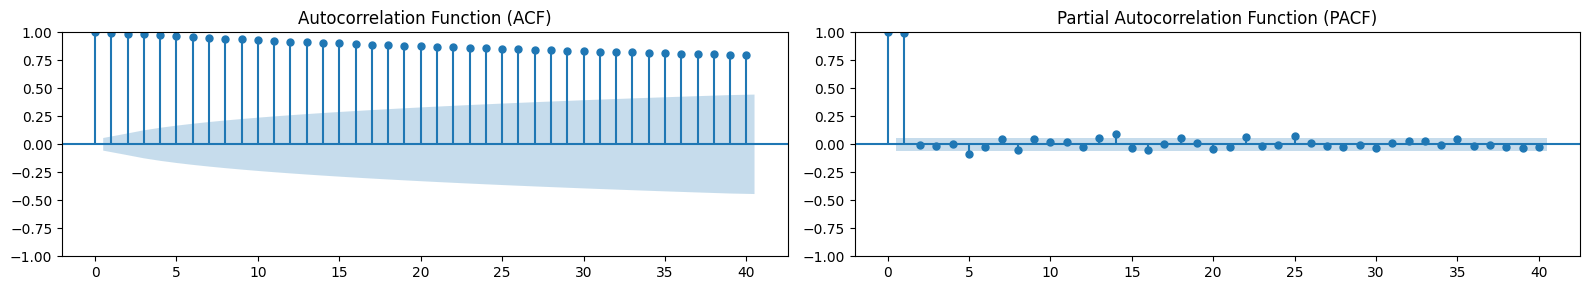

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(data['Adj Close'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(data['Adj Close'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#ARIMA MODEL

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 1  # Autoregressive order
d = 2 # Degree of differencing
q = 2  # Moving average order

# Fit the ARIMA arima_model on training data
arima_model = ARIMA(train_data['Adj Close'], order=(p, d, q))  # Use order=(p, d, q)
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# Make predictions on the test data
forecast_steps = len(test_data)
arima_forecast = arima_model_fit.get_forecast(steps=forecast_steps)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()

# Evaluate arima_model performance
mae_arima = mean_absolute_error(test_data['Adj Close'], arima_forecast_mean)
rmse_arima = np.sqrt(mean_squared_error(test_data['Adj Close'], arima_forecast_mean))
r2_arima = r2_score(test_data['Adj Close'], arima_forecast_mean)

#print values for evalustion metrics
print('ARIMA arima_Model Performance:')
print('MAE: {:.3f}'.format(mae_arima))
print('RMSE: {:.3f}'.format(rmse_arima))
print('R-squared: {:.3f}'.format(r2_arima))


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  968
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -5554.566
Date:                Mon, 23 Dec 2024   AIC                          11117.132
Time:                        07:02:09   BIC                          11136.625
Sample:                             0   HQIC                         11124.553
                                - 968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9765      0.010   -102.739      0.000      -0.995      -0.958
ma.L1         -0.0006      0.042     -0.016      0.988      -0.082       0.081
ma.L2         -0.9994      0.024    -40.885      0.0

### Plot for ARIMA Model





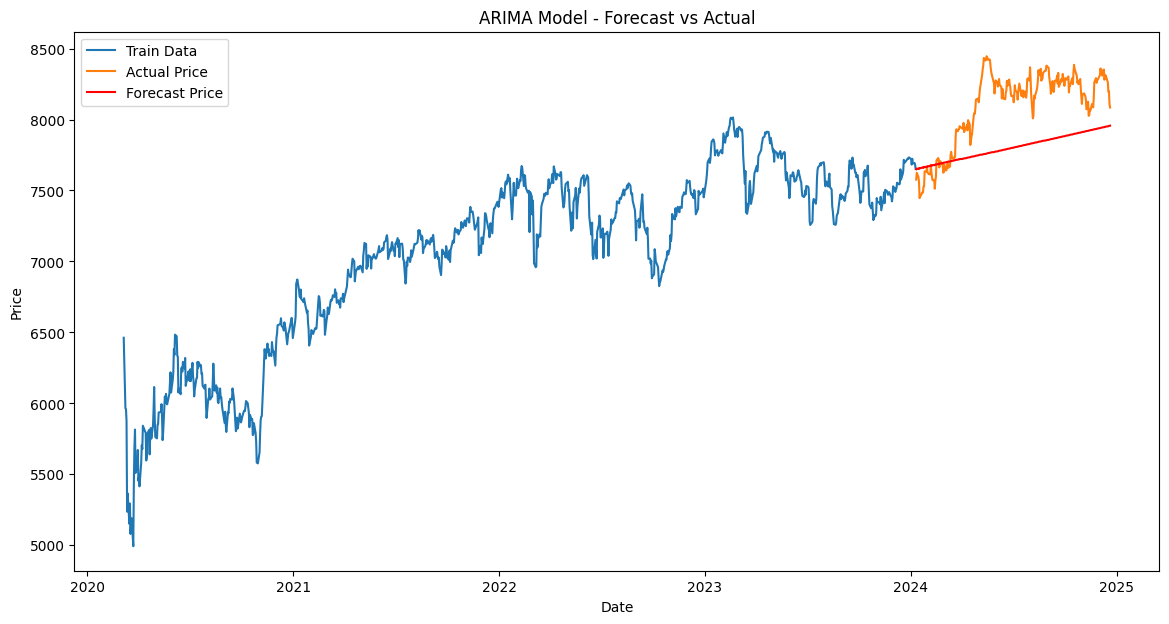

In [ ]:
# Plot the forecast vs actual prices
plt.figure(figsize=(14,7))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Actual Price')
plt.plot(test_data.index, arima_forecast_mean, label='Forecast Price', color='red')
plt.title('ARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#SARIMA MODEL

In [ ]:
order = (1, 1, 2)
seasonal_order = (1, 1, 2, 12) # s=12 for monthly seasonality

# Fit the SARIMA model
sarima_model = SARIMAX(train_data['Adj Close'], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

# Make predictions on the test data
forecast_steps = len(test_data)
sarima_forecast = sarima_model_fit.get_forecast(steps=forecast_steps)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_conf_int = sarima_forecast.conf_int()

# Evaluate SARIMA model performance
mae_sarima = mean_absolute_error(test_data['Adj Close'], sarima_forecast_mean)
rmse_sarima = np.sqrt(mean_squared_error(test_data['Adj Close'], sarima_forecast_mean))
r2_sarima = r2_score(test_data['Adj Close'], sarima_forecast_mean)

#print values for evalustion metrics
print('SARIMA Model Performance:')
print('MAE: {:.3f}'.format(mae_sarima))
print('RMSE: {:.3f}'.format(rmse_sarima))
print('R-squared: {:.3f}'.format(r2_sarima))

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  968
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -5523.093
Date:                            Mon, 23 Dec 2024   AIC                          11060.186
Time:                                    07:02:25   BIC                          11094.218
Sample:                                         0   HQIC                         11073.149
                                            - 968                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4174      2.206      0.189      0.850      -3.907       4.742
ma.L1         -0.4963      2.205   

### Plot for SARIMA Model

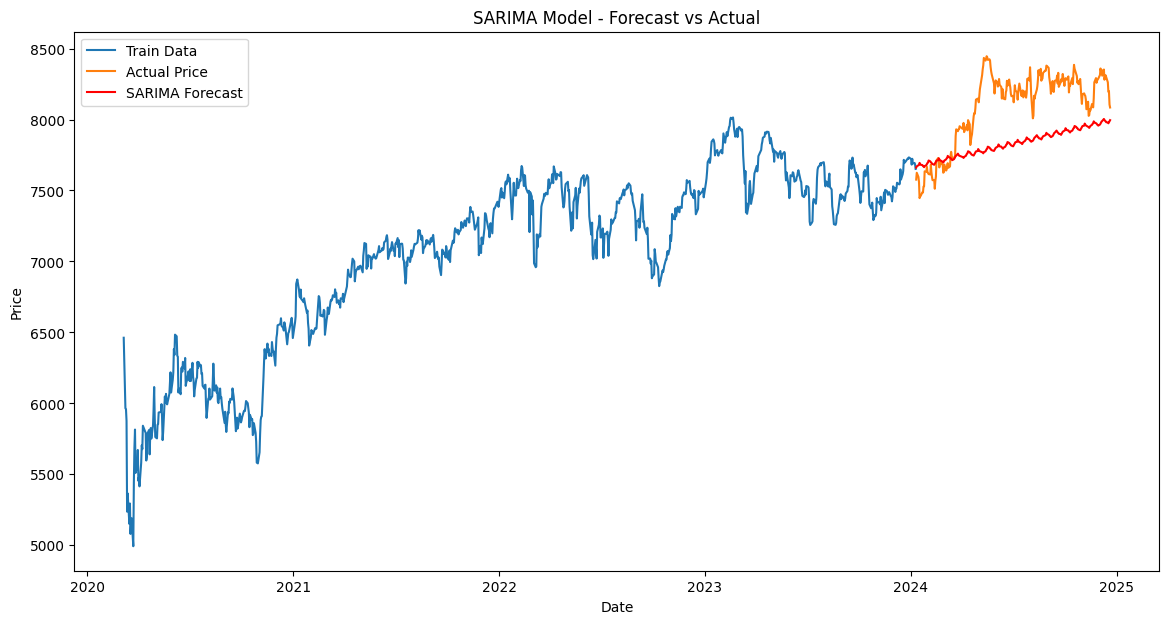

In [ ]:
# Plot the forecast vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Actual Price')
plt.plot(test_data.index, sarima_forecast_mean, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#LSTM Model

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Access the first (and likely only) column using the column name or .iloc
train_scaled = scaler.fit_transform(train_data[['Adj Close']])
test_scaled = scaler.transform(test_data[['Adj Close']])

# Create sequences for LSTM input
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

# Make predictions
train_pred_scaled = model.predict(X_train)
test_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
train_pred = scaler.inverse_transform(train_pred_scaled)
test_pred = scaler.inverse_transform(test_pred_scaled)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance
mae_lstm = mean_absolute_error(y_test_actual, test_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, test_pred))
r2_lstm = r2_score(y_test_actual, test_pred)

#print values for evalustion metrics
print('LSTM Model Performance:')
print(f'MAE: {mae_lstm:.3f}')
print(f'RMSE: {rmse_lstm:.3f}')
print(f'R-squared: {r2_lstm:.3f}')




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2774
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoc

### Plot for LSTM Model

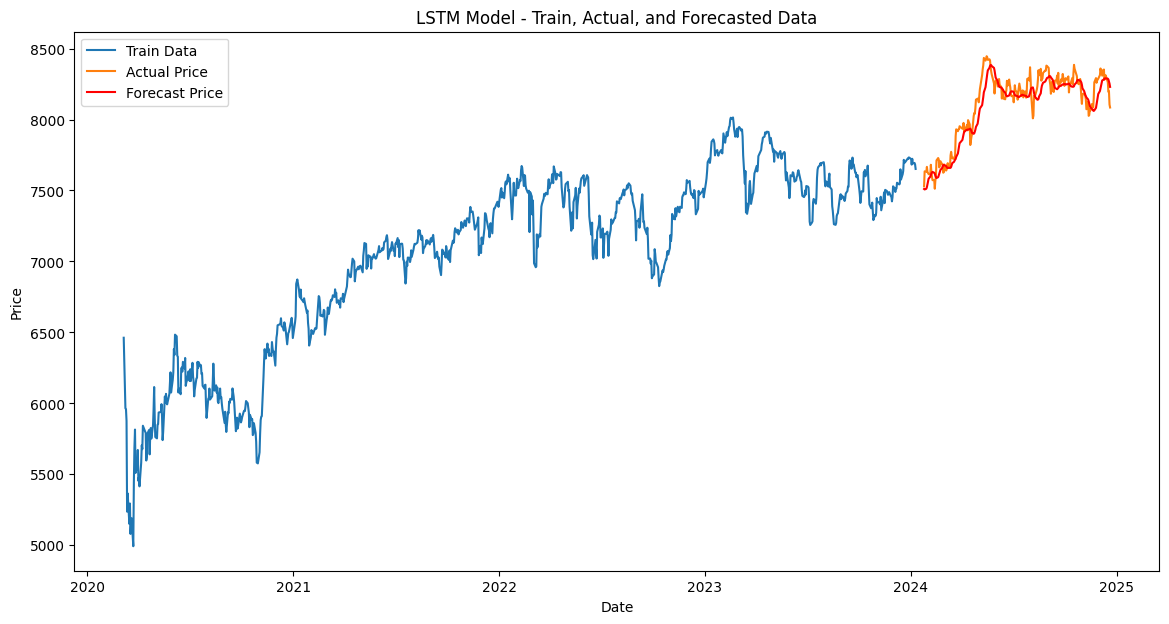

In [ ]:
# Plot the train, actual, and predicted/forecasted data
plt.figure(figsize=(14, 7))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'].iloc[time_steps:], label='Actual Price')
plt.plot(test_data.index[time_steps:], test_pred, label='Forecast Price', color='red')
plt.title('LSTM Model - Train, Actual, and Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Comparision of All Models

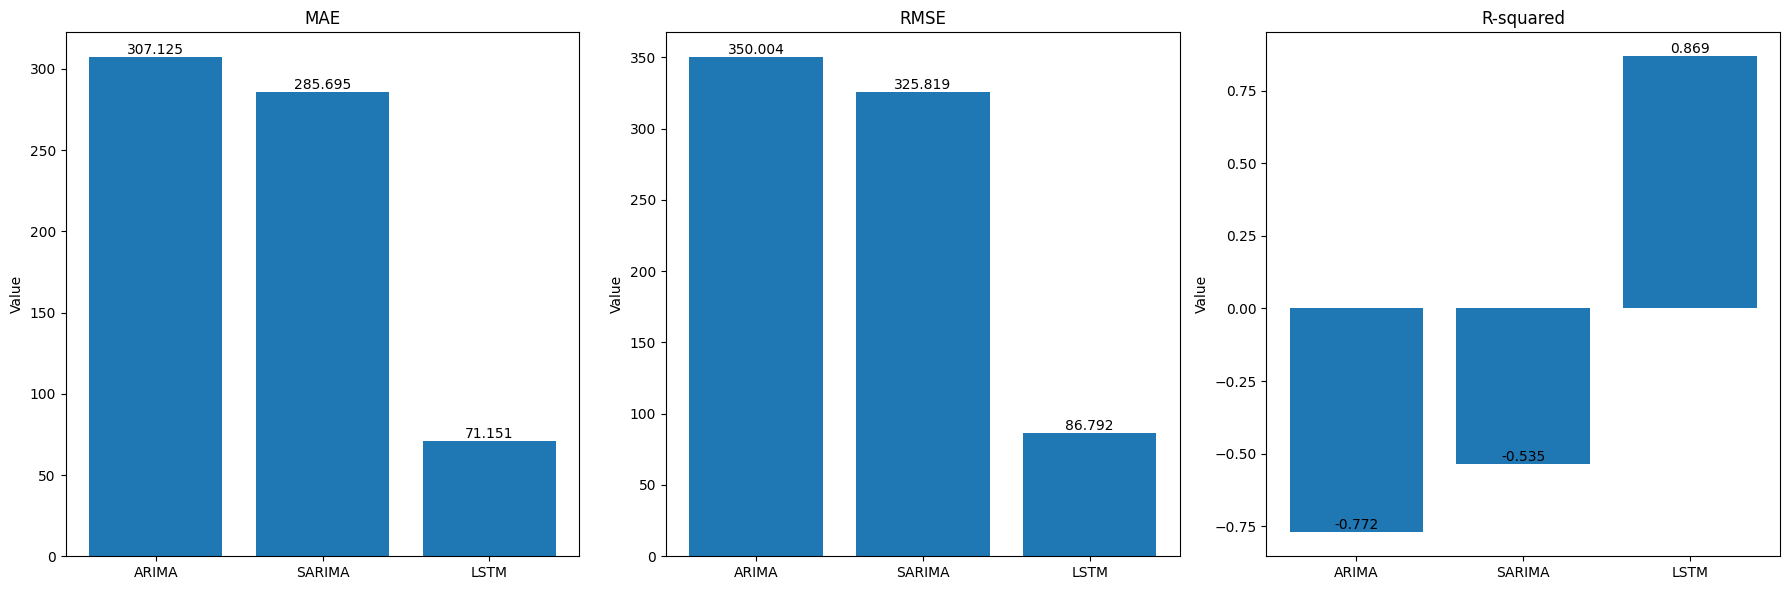

In [ ]:
arima_metrics = {'MAE': mae_arima, 'RMSE': rmse_arima, 'R-squared': r2_arima}  # Replace with actual values
sarima_metrics = {'MAE': mae_sarima, 'RMSE': rmse_sarima, 'R-squared': r2_sarima} # Replace with actual values
lstm_metrics = {'MAE': mae_lstm, 'RMSE': rmse_lstm, 'R-squared': r2_lstm}  # Replace with actual values


metrics = {
    'ARIMA': arima_metrics,
    'SARIMA': sarima_metrics,
    'LSTM': lstm_metrics,
}


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['ARIMA', 'SARIMA', 'LSTM']

for i, metric in enumerate(['MAE', 'RMSE', 'R-squared']):
    ax = axes[i]
    values = [metrics[model][metric] for model in models]
    ax.bar(models, values)
    ax.set_title(metric)
    ax.set_ylabel('Value')
    for j, v in enumerate(values):
        ax.text(j, v, str(round(v,3)), ha='center', va='bottom')


plt.tight_layout()
plt.show()